Realizar estudios de aprendizaje supervisado utilizando árboles de decisión, tanto para clasificiación como para regresión. Para ello en esta tarea se usarán 4 datasets (los tres de la práctica anterior y uno que introduce series temporales).

**Ejercicio 1.** https://www.kaggle.com/yasserh/wine-quality-dataset. Clasifición de la calidad del vino según alguno de sus parámetros (ph, densidad, sulfatos, alcohol, azúcar, etc.). El dataset contiene una serie de datos sobre unos vinos y su calidad (de 0 a 10). Este problema es de clasificación puesto que consiste en clasificar el vino en concreto en su clase de calidad (valores discretos del 0 al 10).

**_Importación de librerías necesarias_**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
from typing import Tuple
import pydot
from IPython.display import Image
from sklearn import tree
from io import StringIO
import joblib

**_Preproceso_**

*Importación de los datos del dataset*

In [ ]:
drive.mount("/content/drive")

df_vino = pd.read_csv("/content/drive/My Drive/IABD/SAA/datasets/Tema 2/vino.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*Mostrar las primera y últimas filas del data frame importado*

In [ ]:
df_vino
# Colab muestra las primeras y últimas filas, si se hace desde un entorno de ejecución diferente que no sea jupiter se haría de la siguiente forma:
# df_vino.head()
# df_vino.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,2
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,3
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1592
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1593
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1594
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1595


*Mostar parámetros estadísticos de los datos (media, desviación típica, quartiles, etc.).*

In [ ]:
df_vino.describe() # Muestro los parámetros estadísticos de los datos antes de ser tratados

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


Tratamos los datos para comprobar si existen outliers.

In [ ]:
def detectarLimitesOutlier(df: pd.DataFrame, k: int = 3) -> Tuple[Tuple[float, ...], Tuple[float, ...]]:
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3 - Q1
  xL = Q1 - k * IQR # Límite inferior
  xU = Q3 + k * IQR # Límite Superior
  return (xL, xU)


# El parámetro listaAtributos no hace falta. Se puede hacer con df.columns
def eliminarOutlier(df: pd.DataFrame, k = 3) -> pd.DataFrame:
  xL, xU = detectarLimitesOutlier(df, k)

  df_sin_outliers = df[~((df < xL) | (df > xU)).any(axis=1)]

  return df_sin_outliers

def outliersCambiarMedia(df: pd.DataFrame, k = 3) -> pd.DataFrame:
  xL, xU = detectarLimitesOutlier(df, k)

  outliers = df[((df < xL) | (df > xU)).any(axis=1)]

  df_sin_outliers = df.copy()
  for columna in df.columns:
      media = df[columna].mean()
      df_sin_outliers[columna] = df[columna].where(~outliers[columna], media)

  return df_sin_outliers

In [ ]:
# Aquí si me funciona

*Mostrar un mapa de calor que indique la correlación entre variables*

<Axes: >

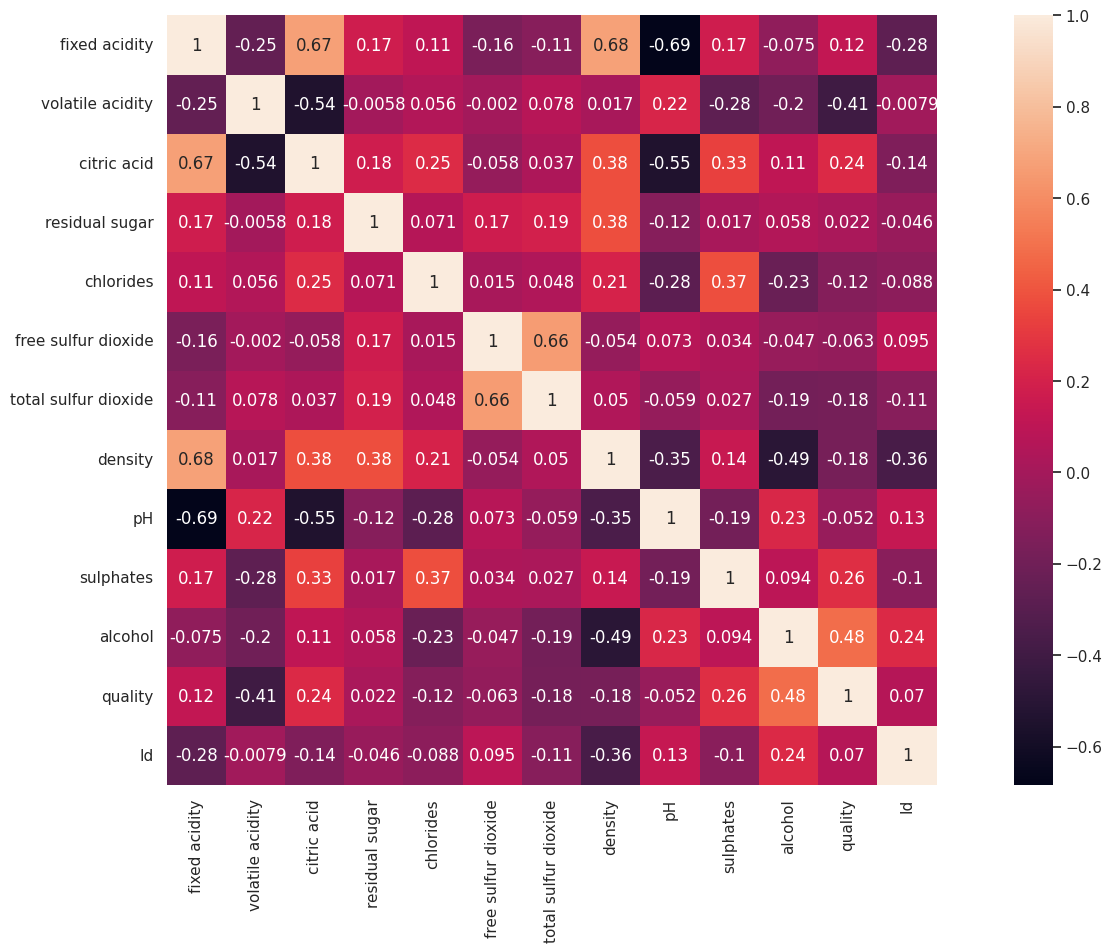

In [ ]:
sns.set(rc={"figure.figsize": (20, 10)}) # Esta es una forma de redimensionar el tamaño de la parcela
# plt.figure(figsize=(15, 8)) # Otra forma para redimensionar el tamaño de la parcela
sns.heatmap(df_vino.corr(), square = True, annot = True)

Seleccionar las características a tener en cuenta en el estudio

Para elegir las características a tener en cuenta en el estudio, va a ser conforme el mapa de calor. Como ya sabemos las mejores características para un estudio son las que más se acerquen a 1 o -1. En este dataset no existe alguna caraterística que tenga una fuerte relación entre las demás características y la objetivo. Las características serán:
- Alcohol
- Sulphates
- Density
- Total sulfur dioxide
- Citric acid
- Volatile acidity

*Separar datos entre datos de entrada y etiquetas (resultados)*

In [ ]:
# Aquí no me funciona la otra función
df_vino = eliminarOutlier(df_vino, 1.5)

x_df_vino = df_vino[["alcohol", "sulphates", "density", "total sulfur dioxide", "citric acid", "volatile acidity"]]
y_df_vino = df_vino['quality']


*Separar datos entre entrenamiento y prueba (usando un 80% para entrenamiento y 20% para test)*

In [ ]:
x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_vino, y_df_vino, random_state=1, test_size=0.2) # Por defecto es 75% de entrenamiento y 25 % de test

**_Entrenamiento y predicción_**

_Elegir, instanciar (eligiendo unos valores concretos, por ejemplo profundidad del árbol 3) y entrenar el modelo._



In [ ]:
# Elijo este modelo porque es un problema de clasificación y no de regresión
modelo = DecisionTreeClassifier(criterion='gini', max_depth=3)
modelo.fit(x_entrenamiento, y_entrenamiento)

DecisionTreeClassifier(max_depth=3)

*Realizar una predicción con los datos de prueba*

In [ ]:
y_prediccion = modelo.predict(x_test)

_Mostrar el árbol de decisión resultante_

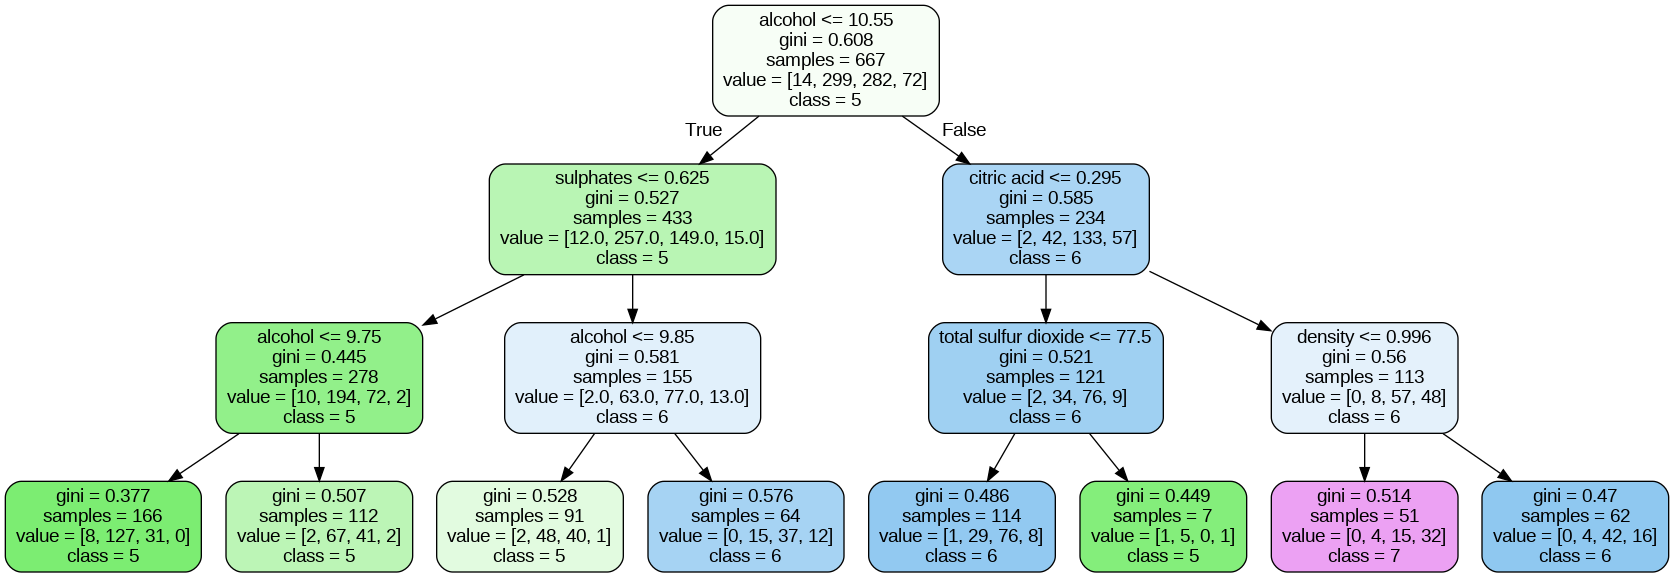

In [ ]:
dot_data = StringIO()

clases = [str(clase) for clase in modelo.classes_]

tree.export_graphviz(modelo, out_file=dot_data, class_names=clases, feature_names=x_entrenamiento.columns, rounded=True, filled=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())

Image(graph[0].create_png())

_Mostrar la importacia de cada atributo en el arbol resultante_

In [ ]:
caracteristicas = ["alcohol", "sulphates", "density", "total sulfur dioxide", "citric acid", "volatile acidity"]
for caracteristica, importancia in zip(caracteristicas, modelo.feature_importances_):
  print(f"{caracteristica}: {importancia:.3f}")

alcohol: 0.568
sulphates: 0.168
density: 0.091
total sulfur dioxide: 0.051
citric acid: 0.122
volatile acidity: 0.000


_Intenta guardar el modelo de predicción ya entrenado usando dump (https://scikit-learn.org/stable/modules/model_persistence.html)_

In [ ]:
# Guardo el modelo. Se guarda el fichero en colab en el directorio /content.
joblib.dump(modelo, "df_vino_modelo_entrenado.joblib")

['df_vino_modelo_entrenado.joblib']

En este ejercicio voy a comprobar que me de la misma probabilidad.

In [ ]:
# Experimento para ver si me lo guarda correctamente y tiene las mismas probabilidades.
print("La probabilidad de acertar es:", accuracy_score(y_test, y_prediccion))

df_vino_guardado = joblib.load("df_vino_modelo_entrenado.joblib")

print("La probabilidad de acertar es:", accuracy_score(y_test, df_vino_guardado.predict(x_test)))

La probabilidad de acertar es: 0.592814371257485
La probabilidad de acertar es: 0.592814371257485


**_Evaluación_**

*Mostrar el porcentaje de elementos correctamente clasificados*

In [ ]:
print("La probabilidad de acertar es:", accuracy_score(y_test, y_prediccion))

La probabilidad de acertar es: 0.592814371257485


*Mostrar la predicción realiza (imprimir la variable con la predicción)*

In [ ]:
print(y_prediccion)

[5 7 5 5 6 5 6 6 6 5 6 5 6 5 7 5 5 5 5 6 5 6 5 5 6 6 7 5 6 6 6 5 5 5 5 5 5
 5 6 5 5 5 5 5 6 5 5 5 7 6 6 7 6 6 7 5 5 5 6 7 6 6 6 6 6 5 6 6 6 6 7 7 5 5
 5 7 5 5 5 6 5 5 5 7 5 6 5 5 5 5 5 5 5 6 5 6 5 5 6 7 6 6 7 5 5 5 6 6 6 5 6
 5 5 6 5 5 5 5 5 5 6 6 5 5 6 5 6 5 6 5 7 6 5 5 5 5 6 5 5 5 7 5 5 7 6 5 5 5
 6 7 6 6 5 5 6 5 6 5 7 6 5 5 5 5 6 6 5]


*Representar gráficamente la clasificación obtenida (matríz de confusión).*

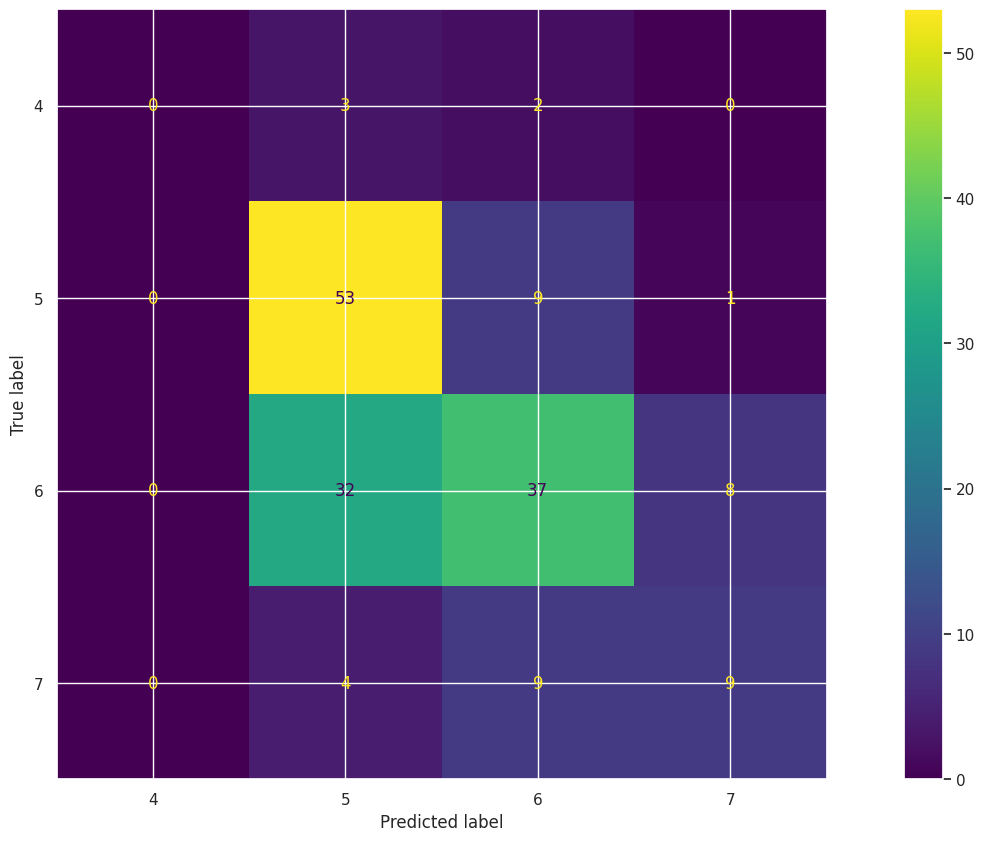

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_prediccion)

**_Optimización de hiperparámetros_**

En estos apartados voy a desacerme del atributo volatile acidity porque en la importancia de los atributos del modelo tiene un valor de 0.00

_Calcula la combinación de parámetros óptima (profundidad de árbol y criterio). Para ello realiza ejecuciones con cada uno de los valores del criterio para los valores de profundidad de árbol de 1 a 15._

In [ ]:
# gini
df_vino = eliminarOutlier(df_vino, 1.5)

x_df_vino = df_vino[["alcohol", "sulphates", "density", "total sulfur dioxide", "citric acid"]]
y_df_vino = df_vino['quality']

df_opt = pd.DataFrame(data={}, columns=["max_depth", "prob_acertar"])

x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_vino, y_df_vino, random_state=1, test_size=0.2)

for i in range(1, 16):
  modelo = DecisionTreeClassifier(criterion='gini', max_depth=i)
  modelo.fit(x_entrenamiento, y_entrenamiento)

  y_prediccion = modelo.predict(x_test)

  df_opt.loc[len(df_opt)] = [i, accuracy_score(y_test, y_prediccion)]

print("Criterio elegido Gini: ")
df_opt

Criterio elegido Gini: 


,max_depth,prob_acertar
0,1.0,0.537931
1,2.0,0.531034
2,3.0,0.586207
3,4.0,0.558621
4,5.0,0.558621
5,6.0,0.593103
6,7.0,0.565517
7,8.0,0.579310
8,9.0,0.572414
9,10.0,0.558621


In [ ]:
# entropy
df_vino = eliminarOutlier(df_vino, 1.5)

x_df_vino = df_vino[["alcohol", "sulphates", "density", "total sulfur dioxide", "citric acid"]]
y_df_vino = df_vino['quality']

df_opt = pd.DataFrame(data={}, columns=["max_depth", "prob_acertar"])

x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_vino, y_df_vino, random_state=1, test_size=0.2)

for i in range(1, 16):
  modelo = DecisionTreeClassifier(criterion='entropy', max_depth=i)
  modelo.fit(x_entrenamiento, y_entrenamiento)

  y_prediccion = modelo.predict(x_test)

  df_opt.loc[len(df_opt)] = [i, accuracy_score(y_test, y_prediccion)]

print("Criterio elegido entropy: ")
df_opt

Criterio elegido entropy: 


,max_depth,prob_acertar
0,1.0,0.570370
1,2.0,0.592593
2,3.0,0.592593
3,4.0,0.614815
4,5.0,0.548148
5,6.0,0.555556
6,7.0,0.570370
7,8.0,0.488889
8,9.0,0.585185
9,10.0,0.585185


_Cada ejecución anterior se deberá hacer usando validación cruzada (por ejemplo n_splits = 5). Con ello obtendremos una medida de bondad del modelo (accuaracy_score o mean_absolute_error), como lo ejecutaremos 5 vedes, calcularemos la media de esas 5 ejecuciones._

In [ ]:
# gini
df_vino = eliminarOutlier(df_vino, 1.5)

x_df_vino = df_vino[["alcohol", "sulphates", "density", "total sulfur dioxide", "citric acid"]]
y_df_vino = df_vino['quality']

df_opt = pd.DataFrame(data={}, columns=["max_depth", "prob_acertar"])

x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_vino, y_df_vino, random_state=1, test_size=0.2)

kf = KFold(n_splits=5, shuffle=True, random_state=1)

for i in range(1, 16):
  modelo = DecisionTreeClassifier(max_depth=i)
  puntuaciones = cross_val_score(modelo, x_entrenamiento, y_entrenamiento, cv=kf, scoring='accuracy')


  df_opt.loc[len(df_opt)] = [i, np.mean(puntuaciones)]

print("Criterio elegido Gini: ")
df_opt

Criterio elegido Gini: 


,max_depth,prob_acertar
0,1.0,0.580769
1,2.0,0.584615
2,3.0,0.567308
3,4.0,0.575000
4,5.0,0.594231
5,6.0,0.565385
6,7.0,0.563462
7,8.0,0.563462
8,9.0,0.553846
9,10.0,0.532692


In [ ]:
# entropy
df_vino = eliminarOutlier(df_vino, 1.5)

x_df_vino = df_vino[["alcohol", "sulphates", "density", "total sulfur dioxide", "citric acid"]]
y_df_vino = df_vino['quality']

df_opt = pd.DataFrame(data={}, columns=["max_depth", "prob_acertar"])

x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_vino, y_df_vino, random_state=1, test_size=0.2)

kf = KFold(n_splits=5, shuffle=True, random_state=1)

for i in range(1, 16):
  modelo = DecisionTreeClassifier(max_depth=i)
  puntuaciones = cross_val_score(modelo, x_entrenamiento, y_entrenamiento, cv=kf, scoring='accuracy')


  df_opt.loc[len(df_opt)] = [i, np.mean(puntuaciones)]

print("Criterio elegido entropy: ")
df_opt

Criterio elegido entropy: 


,max_depth,prob_acertar
0,1.0,0.560851
1,2.0,0.558871
2,3.0,0.544970
3,4.0,0.548931
4,5.0,0.536891
5,6.0,0.532851
6,7.0,0.546733
7,8.0,0.518832
8,9.0,0.522832
9,10.0,0.514891


_Finalmente los parámetros elegidos serán los que den mejor media de esas medidas anteriormente nombradas._

El mejor resultado obtenido es con entropy y una profundidad máxima de 6, aunque en la profundidad 4 y 5 disminuye lo que puede ser que a partir de esos pasos empiece el sobreajuste.

_Una vez obtenidos esos parámetros óptimos los aplicaremos al problema en cuestión y mostramos los resultados._

In [ ]:
df_vino = eliminarOutlier(df_vino, 1.5)

x_df_vino = df_vino[["alcohol", "sulphates", "density", "total sulfur dioxide", "citric acid"]]
y_df_vino = df_vino['quality']

df_opt = pd.DataFrame(data={}, columns=["max_depth", "prob_acertar"])

x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_vino, y_df_vino, random_state=1, test_size=0.2)

modelo = DecisionTreeClassifier(criterion='entropy', max_depth=6)
modelo.fit(x_entrenamiento, y_entrenamiento)

y_prediccion = modelo.predict(x_test)

print("La probabilidad de acertar es: ", accuracy_score(y_test, y_prediccion))

La probabilidad de acertar es:  0.5555555555555556
